In [1]:
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from pyvene import (
    ConstantSourceIntervention,
    LocalistRepresentationIntervention,
    IntervenableConfig,
    RepresentationConfig,
    IntervenableModel,
    embed_to_distrib,
    top_vals,
    VanillaIntervention,
)
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Llama-3.1 8B
MODEL = "meta-llama/Llama-3.1-8b"
HF_TOKEN = "..."
tokenizer = AutoTokenizer.from_pretrained(MODEL, token=HF_TOKEN)
model = AutoModelForCausalLM.from_pretrained(MODEL, device_map="auto", torch_dtype=torch.float16, token=HF_TOKEN)
model.eval()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

### Factual Recall

Let’s set up the model and test it on the fact we want to causal trace: “A cat sat on the mat and he”.

In [3]:
def get_probs(out):
    last_logits = out.logits[0, -1]            # (vocab_size,)
    dist = F.softmax(last_logits, dim=-1)

    topk      = torch.topk(dist, k=10)
    top_ids   = topk.indices.tolist()
    top_probs = topk.values.tolist()
    
    return topk, top_ids, top_probs

In [14]:
# Example: one-shot prompt
few_shot = (
    "Lily the cat relaxes on the mat and she eats an apple.\n"
    "Lily the cat sat on the mat and she smelled an apple.\n"
    "Lily the cat relaxes on the mat and she"
)
gold = "eats"
inputs = tokenizer(few_shot, return_tensors="pt").to(device)

with torch.no_grad():
    out = model(**inputs)
    
topk, top_ids, top_probs = get_probs(out)

print(few_shot)
for tok_id, prob in zip(top_ids, top_probs):
    token = tokenizer.decode([tok_id]).strip()
    print(f"{token}\t{prob:.4f}")

Lily the cat relaxes on the mat and she eats an apple.
Lily the cat sat on the mat and she smelled an apple.
Lily the cat relaxes on the mat and she
eats	0.4905
smells	0.1721
sees	0.0237
drinks	0.0226
ate	0.0219
tastes	0.0206
looks	0.0105
plays	0.0077
ch	0.0070
bites	0.0070


### Intervention

In [15]:
# 1) Define the noise intervention class
class NoiseIntervention(ConstantSourceIntervention, LocalistRepresentationIntervention):
    def __init__(self, embed_dim=None, **kwargs):
        super().__init__()
        # pull the provided size
        embed_dim = embed_dim or kwargs.get("latent_dim")
        if embed_dim is None:
            raise ValueError(f"No latent_dim in kwargs: {list(kwargs)}")
        self.interchange_dim = embed_dim

        rs = np.random.RandomState(1)
        prng = lambda *shape: rs.randn(*shape)
        self.noise = torch.from_numpy(prng(1, 1, embed_dim)).to(device)
#         self.noise_level = 0.13462981581687927
        self.noise_level = 0.33462981581687927

    def forward(self, base, source=None, subspaces=None):
        base[..., :self.interchange_dim] += self.noise * self.noise_level
        return base
    
# 2) Build a corrupt config for Llama-3.1 8B
def corrupted_config(model_type, layer):
    return IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,
                "block_input"
            ),
        ],
        intervention_types=NoiseIntervention,
    )

In [16]:
# 5) Create intervenable wrapper for a given layer
layer = 0

base = tokenizer(few_shot, return_tensors="pt").to(device)
config = corrupted_config(type(model), layer)
intervenable = IntervenableModel(config, model)

Let’s check that this reduced the probability of the output past tense verbs.

In [17]:
# prompt = "Lily the cat relaxed on the mat and she"
inputs = tokenizer(few_shot, return_tensors="pt")
input_ids = inputs["input_ids"][0].tolist()
tokens    = tokenizer.convert_ids_to_tokens(input_ids)

# print token indices
for idx, tok in enumerate(tokens):
    print(idx, tok)

0 <|begin_of_text|>
1 L
2 ily
3 Ġthe
4 Ġcat
5 Ġrelax
6 es
7 Ġon
8 Ġthe
9 Ġmat
10 Ġand
11 Ġshe
12 Ġeats
13 Ġan
14 Ġapple
15 .Ċ
16 L
17 ily
18 Ġthe
19 Ġcat
20 Ġsat
21 Ġon
22 Ġthe
23 Ġmat
24 Ġand
25 Ġshe
26 Ġsmelled
27 Ġan
28 Ġapple
29 .Ċ
30 L
31 ily
32 Ġthe
33 Ġcat
34 Ġrelax
35 es
36 Ġon
37 Ġthe
38 Ġmat
39 Ġand
40 Ġshe


In [18]:
pos_restore = [5,6,12,34,35]

In [19]:
# 2) Intervention at token
unit_locations = {
    "base": [[           # one batch
      pos_restore
    ]]
}

_, counterfactual_outputs = intervenable(base, unit_locations=unit_locations)

# 3) Extract logits & distributions
topk, top_ids, top_probs = get_probs(counterfactual_outputs)

# Decode and print
print(few_shot)
for tok_id, prob in zip(top_ids, top_probs):
    token = tokenizer.decode([tok_id]).strip()
    print(f"{token}\t{prob:.4f}")

Lily the cat relaxes on the mat and she eats an apple.
Lily the cat sat on the mat and she smelled an apple.
Lily the cat relaxes on the mat and she
ate	0.1407
smelled	0.0719
liked	0.0353
read	0.0340
sm	0.0269
smells	0.0241
’s	0.0214
sat	0.0188
wrote	0.0159
had	0.0152


### Restored run

We now make a config that performs the following:

- Corrupt input embeddings for some positions.

- Restore the hidden state at a particular layer for some (potentially different positions).

This is how Meng et al. check where in the model the fact moves through.

In [20]:
def restore_corrupted_with_interval_config(
    intervened_layer: int,
    restore_layer: int,
    stream: str = "mlp",
    window: int = 2,
    num_layers: int = 33,
):
    # compute restore interval around restore_layer
    half = window // 2
    start = max(0, restore_layer - half)
    end   = min(num_layers, restore_layer + half + 1)
    
    reps = []
    types = []
    
    # First: corrupt the embedding of token position later
    reps.append(
      RepresentationConfig(
        0,
        "block_input"
      )
    )
    types.append(NoiseIntervention)
    
    # Then: restore hidden state at each layer in [start, end)
    for L in range(start, end):
        reps.append(
          RepresentationConfig(
            L,
            stream 
          )
        )
        types.append(VanillaIntervention)
    
    return IntervenableConfig(
      model_type=type(model),
      representations=reps,
      intervention_types=types
    )

Now let’s run this over all layers and positions! We will corrupt position 3 (“sat”, i.e. the past tense verb) and restore at a single position at every layer.

In [21]:
token_id = tokenizer.encode(f" {gold}", add_special_tokens=False)[0]
base = tokenizer(few_shot, return_tensors="pt").to(device)

token_id

50777

llama_type_to_module_mapping:
https://github.com/stanfordnlp/pyvene/blob/main/pyvene/models/llama/modelings_intervenable_llama.py

In [22]:
for stream in ["block_output", "mlp_activation", "attention_output", "mlp_output"]:
    records = []
    for restore_layer in range(33):
        for pos in range(inputs.input_ids.size(1)):
            cfg = restore_corrupted_with_interval_config(
                intervened_layer=0,      # we only corrupt at input
                restore_layer=restore_layer,
                stream=stream,
                window=2,
                num_layers=model.config.num_hidden_layers
            )
            interv = IntervenableModel(cfg, model)
            
            # sources→targets mapping: corrupt at embed_tokens output, restore at each hidden stream
            n_restores = len(cfg.representations) - 1
            _, cf_out = interv(
                base,
                [None] + [base]*n_restores,
                {
                    "sources->base": (
                        [None] + [[[pos]]]*n_restores,
                        [[pos_restore]] + [[[pos]]]*n_restores,
                    )
                },
            )
            
            dist = cf_out.logits.softmax(-1)
            prob = dist[0, -1, token_id].item()
            
            # Extract the top‐1 predicted token and its probability
            top_val, top_idx = torch.topk(dist[0, -1], k=1)
            top_id   = top_idx.item()
            top_prob = top_val.item()
            top_tok  = tokenizer.decode([top_id]).strip()
            
            records.append({
                "restore_layer": restore_layer,
                "pos": pos,
                "stream": stream,
                "prob": prob,
                "top_token": top_tok,
                "top_prob": top_prob,
            })
    
    pd.DataFrame(records).to_csv(f"pyvene_past_{stream}.csv", index=False)

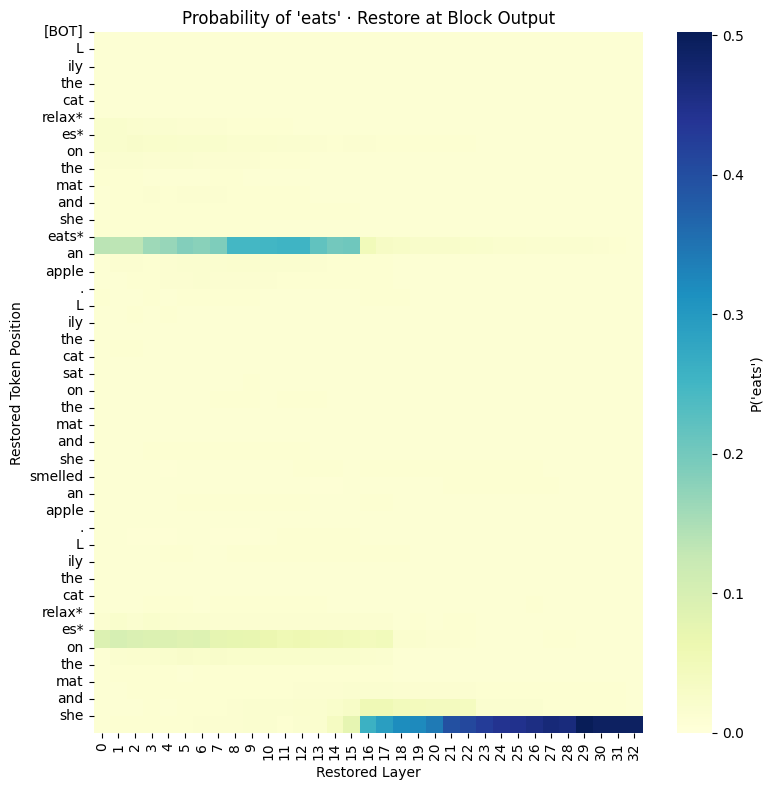

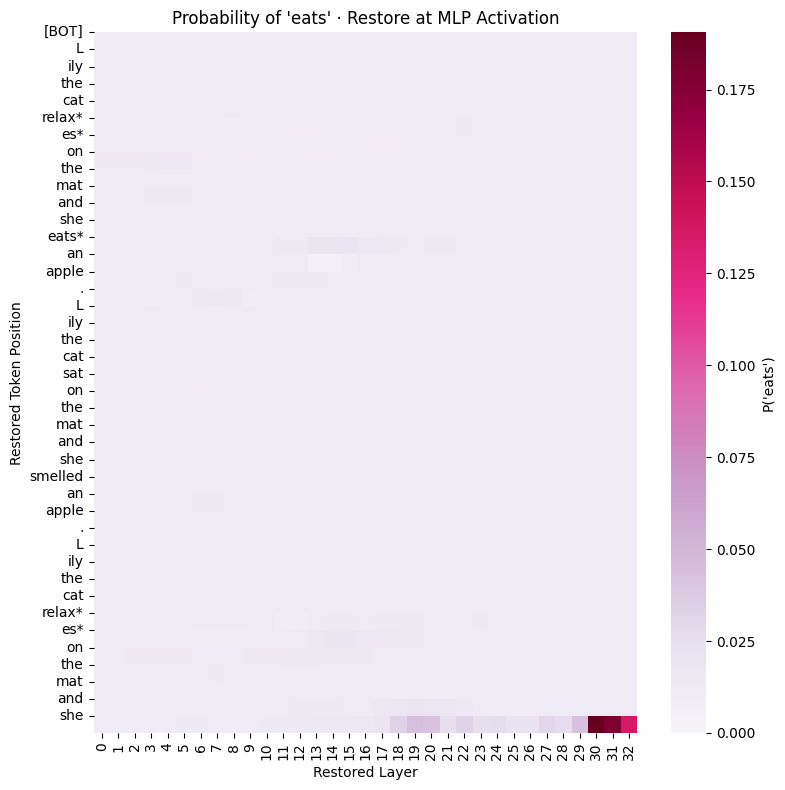

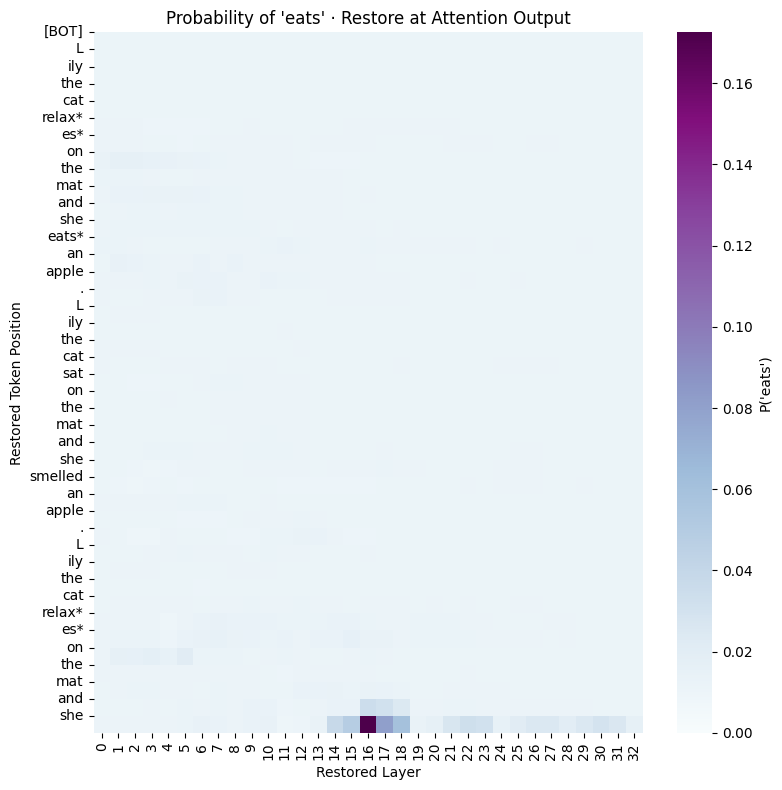

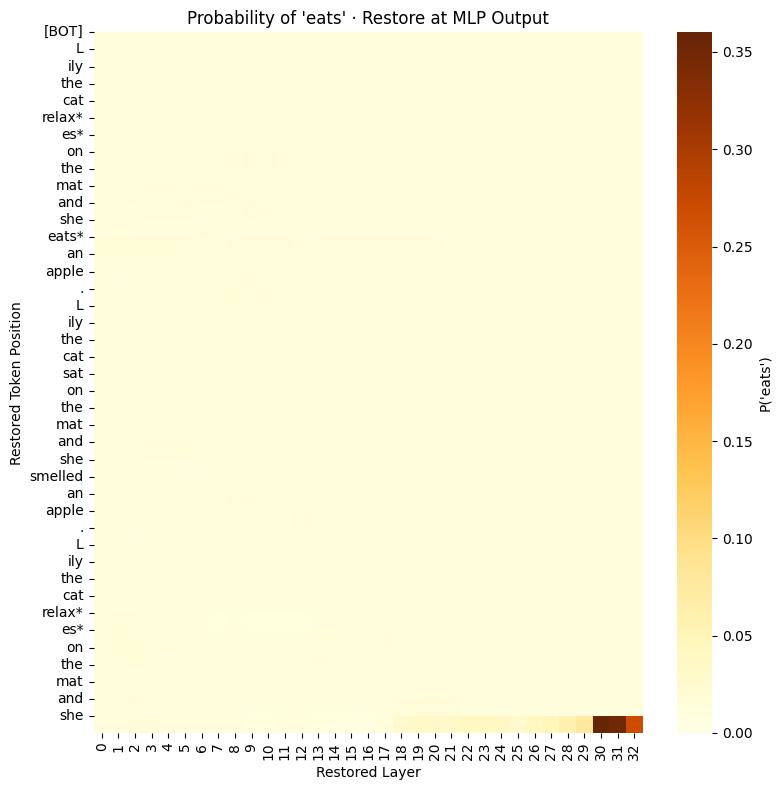

In [23]:
# Shared settings
streams = ["block_output", "mlp_activation", "attention_output", "mlp_output"]

custom_labels = ["[BOT]", "L", "ily", "the", "cat", "relax*", "es*", "on", "the", "mat", "and", "she", "eats*", "an", "apple", ".",
                "L", "ily", "the", "cat", "sat", "on", "the", "mat", "and", "she", "smelled", "an", "apple", ".",
                "L", "ily", "the", "cat", "relax*", "es*", "on", "the", "mat", "and", "she"]
breaks = list(range(len(custom_labels)))
cmaps = {
    "block_output": "YlGnBu",
    "mlp_activation": "PuRd",
    "attention_output": "BuPu",
    "mlp_output": "YlOrBr"
}
titles = {
    "block_output": "Block Output",
    "mlp_activation": "MLP Activation",
    "attention_output": "Attention Output",
    "mlp_output": "MLP Output"
}

for stream in streams:
    # Load and prepare
    df = pd.read_csv(f"pyvene_past_{stream}.csv")
    df["layer"] = df["restore_layer"].astype(int)
    df["pos"]   = df["pos"].astype(int)
    df["p_was"] = df["prob"].astype(float)

    # Pivot: rows=pos, cols=layer
    pivot = df.pivot(index="pos", columns="layer", values="p_was")

    # Plot heatmap
    plt.figure(figsize=(8, 8))
    ax = sns.heatmap(
        pivot,
        cmap=cmaps[stream],
        vmin=0, 
        cbar_kws={"label": f"P('{gold}')"}
    )
    ax.set_title(f"Probability of '{gold}' · Restore at {titles[stream]}")
    ax.set_xlabel("Restored Layer")
    ax.set_ylabel("Restored Token Position")
    ax.set_yticks(breaks)
    ax.set_yticklabels(custom_labels, rotation=0)

    plt.tight_layout()
    plt.show()

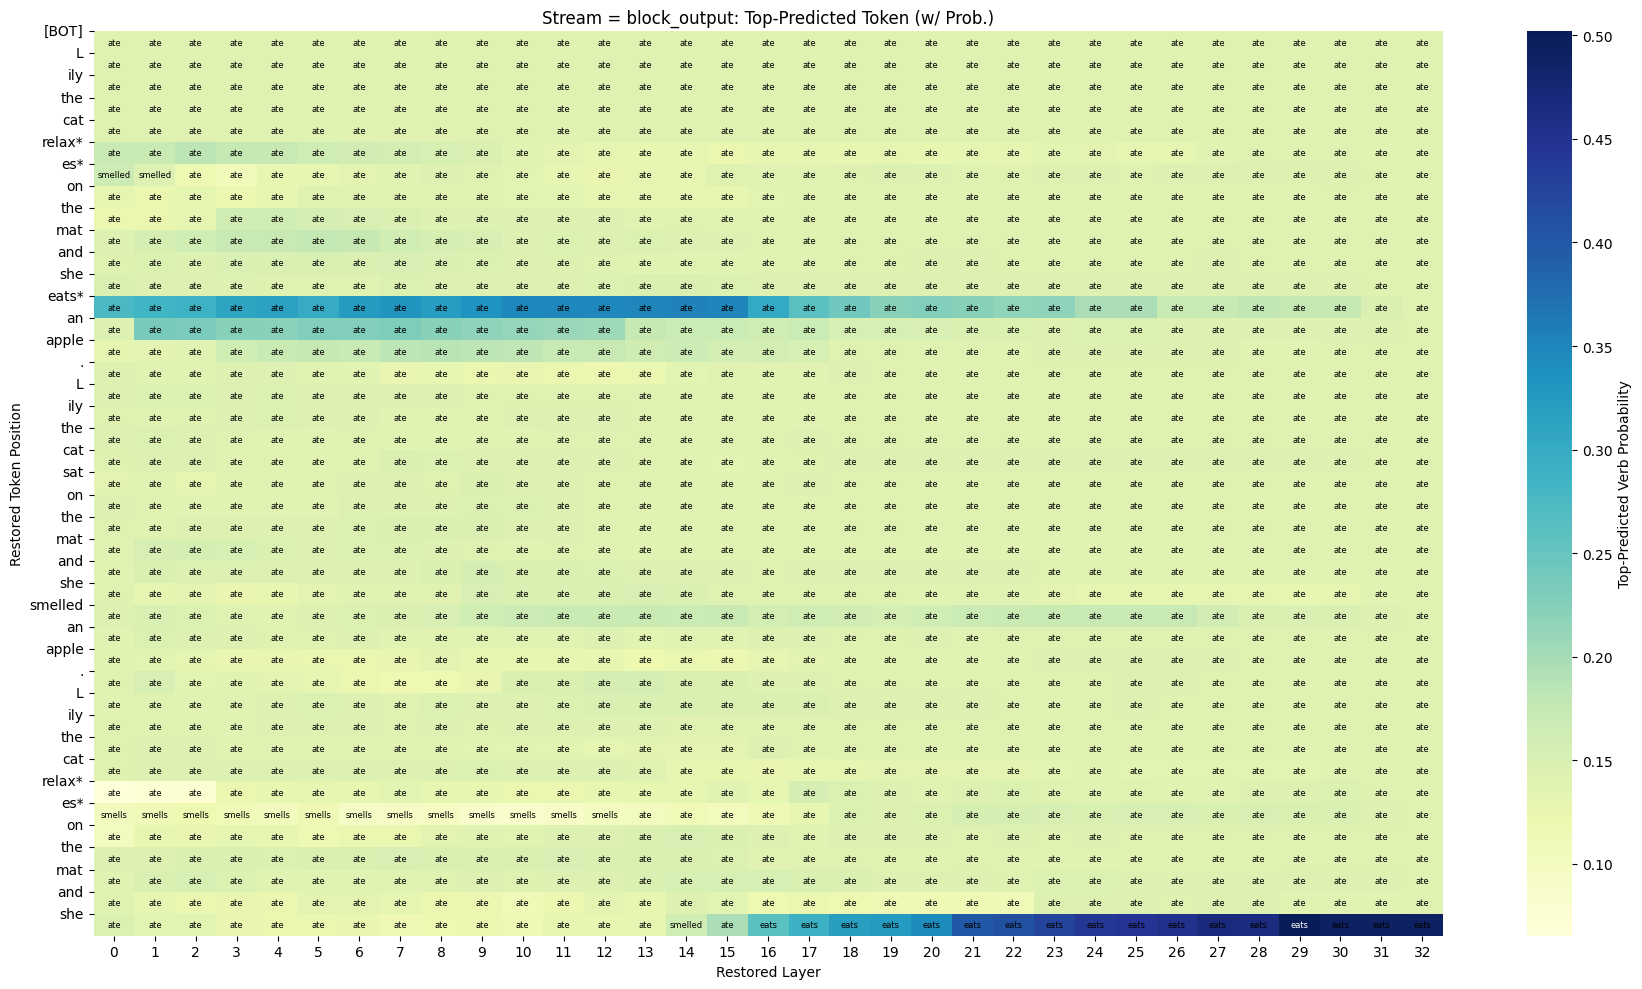

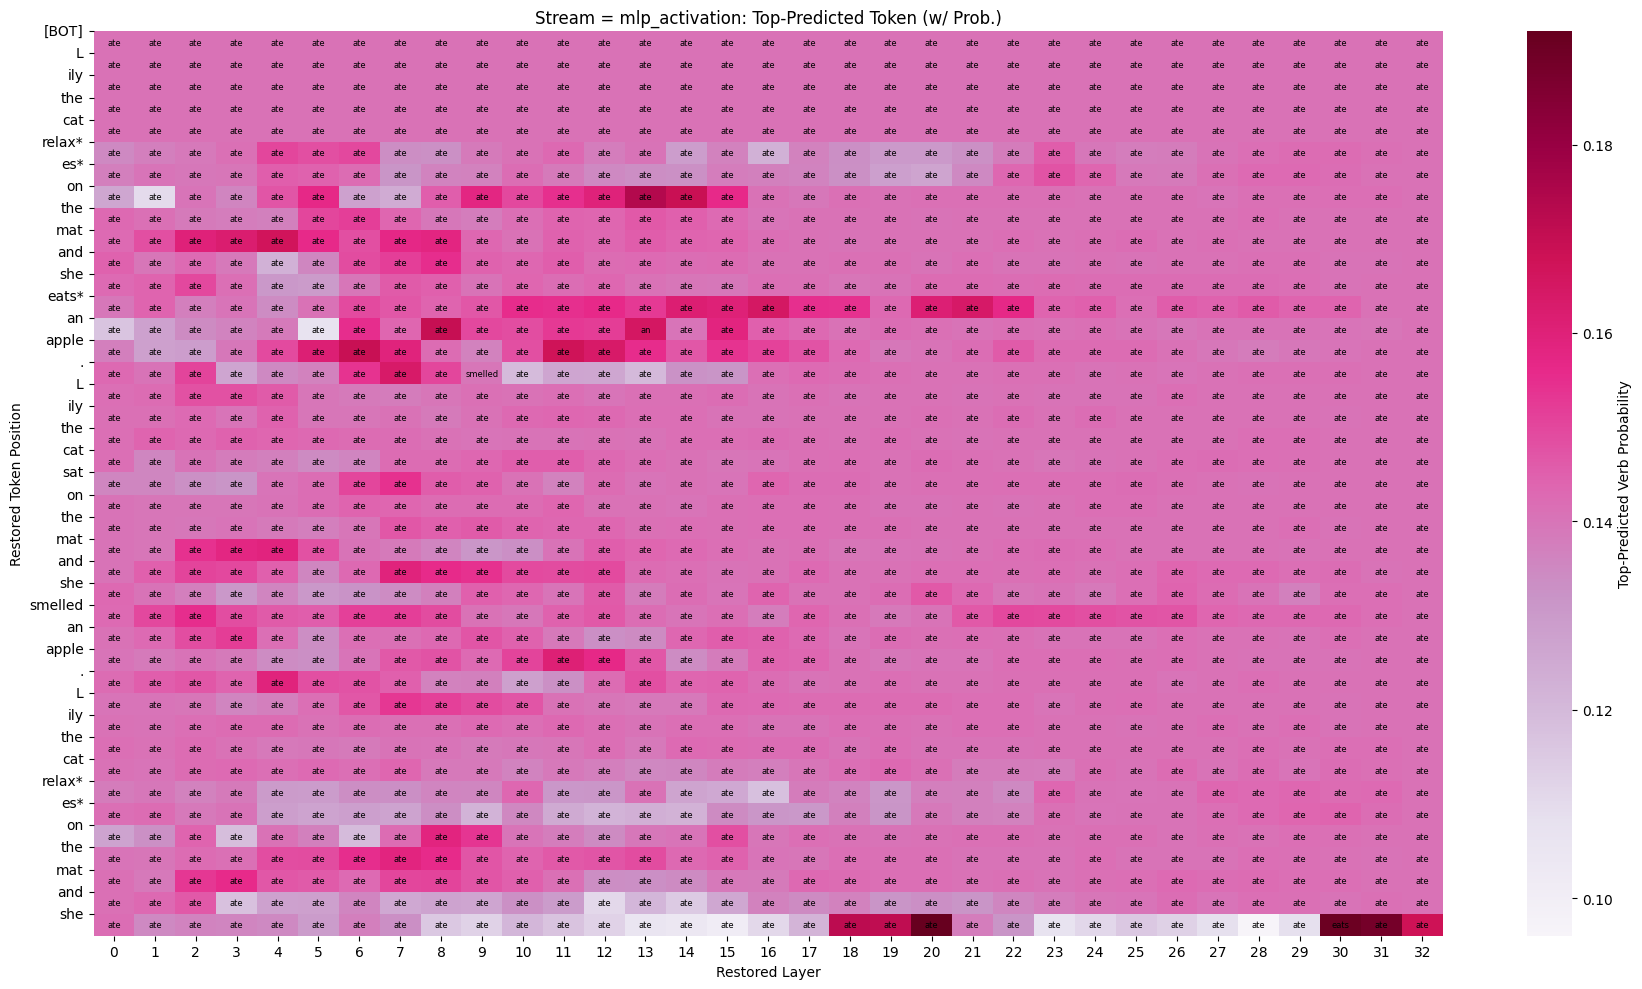

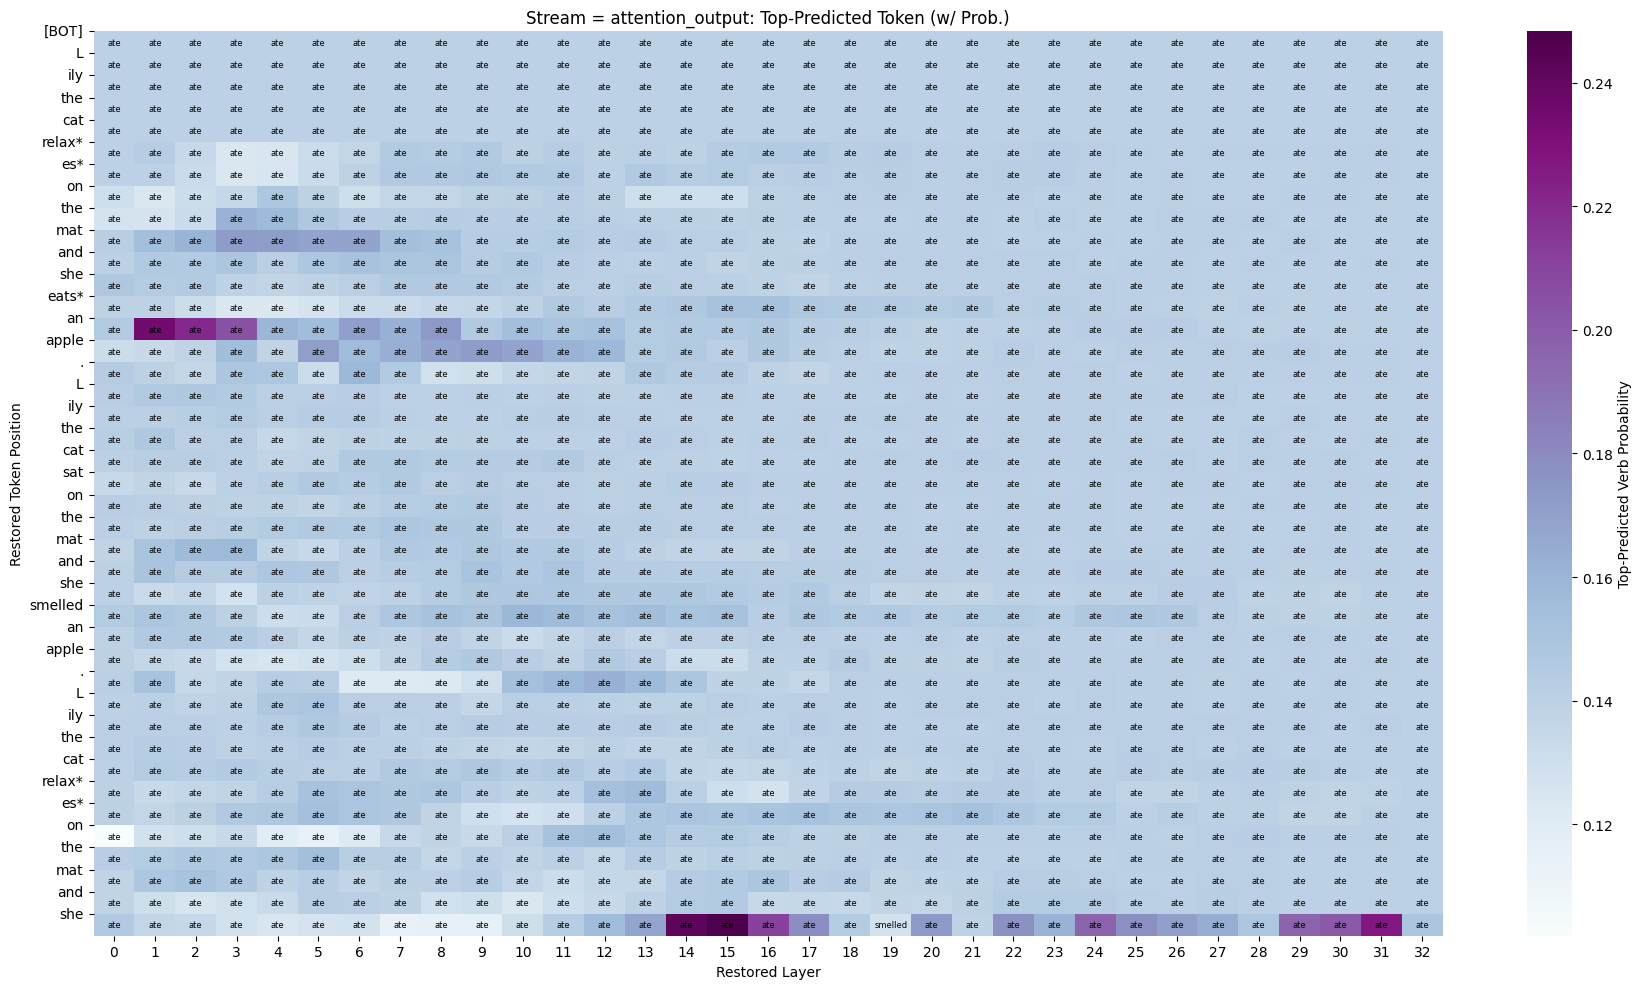

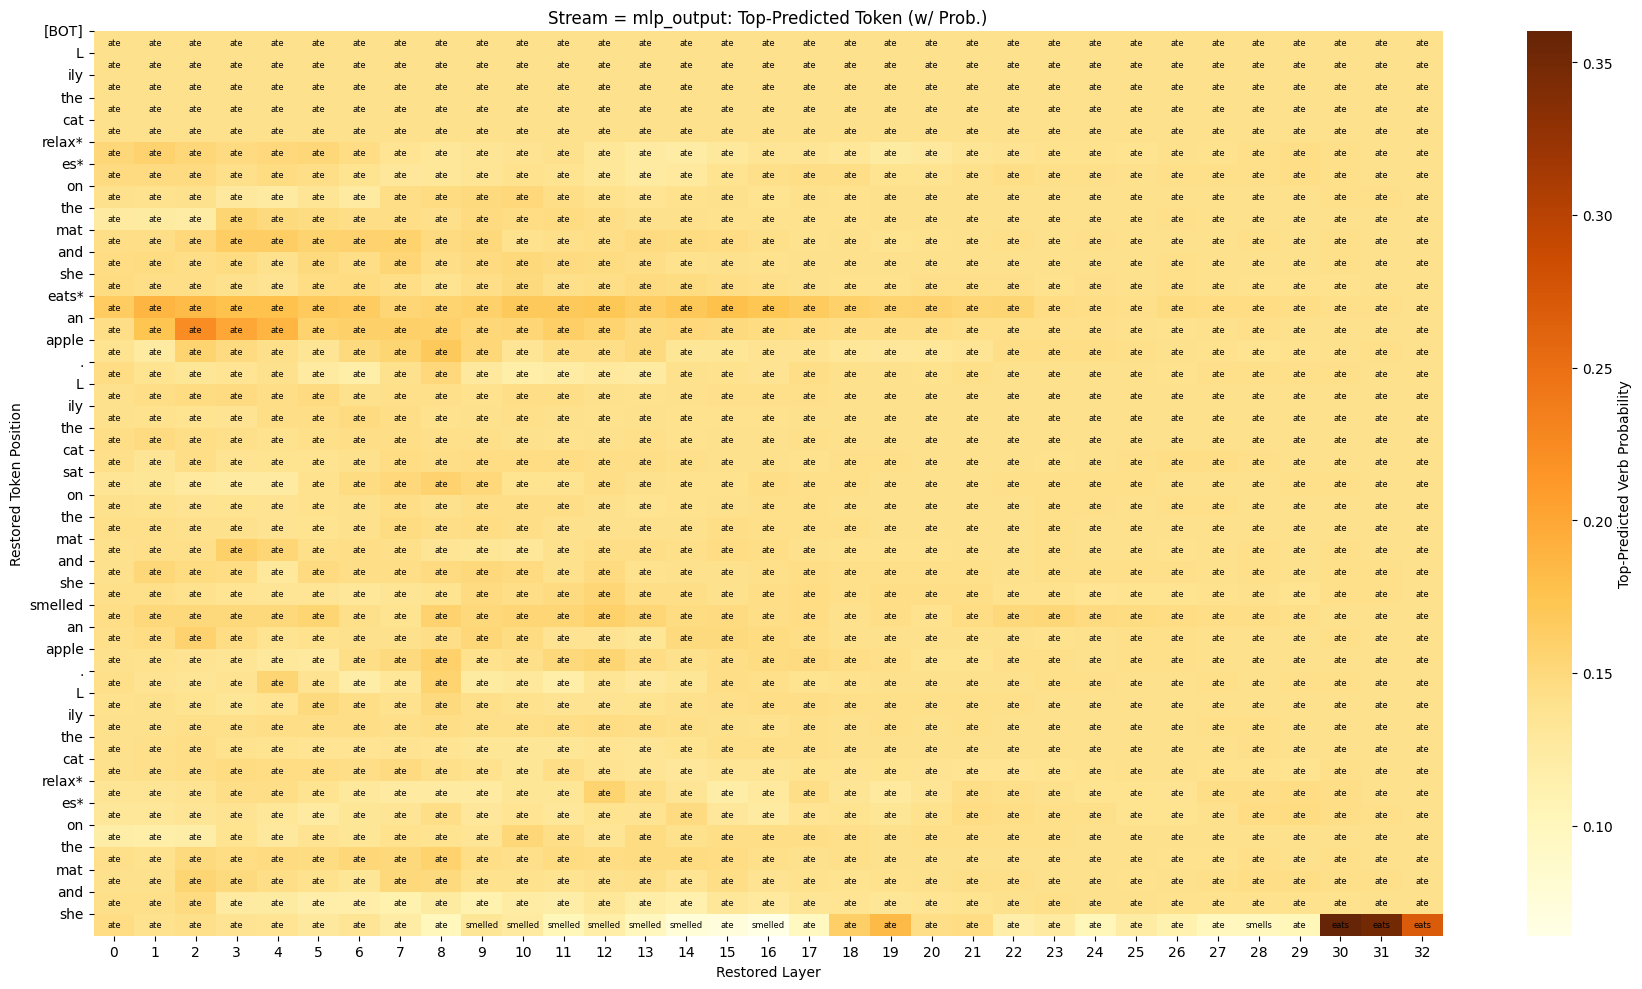

In [24]:
for stream in streams:
    # Load and prepare
    df = pd.read_csv(f"pyvene_past_{stream}.csv")
    df_stream = df[df["stream"] == stream]
    pivot_prob  = df_stream.pivot(index="pos", columns="restore_layer", values="top_prob")
    pivot_token = df_stream.pivot(index="pos", columns="restore_layer", values="top_token")

    # align token‐pivot to prob‐pivot shape
    pivot_token = pivot_token.reindex(
        index = pivot_prob.index,
        columns = pivot_prob.columns
    )

    plt.figure(figsize=(18, 10))
    ax = sns.heatmap(pivot_prob, cmap=cmaps[stream], cbar_kws={"label": "Top‐Predicted Verb Probability"})
    for i, pos in enumerate(pivot_prob.index):
        for j, layer in enumerate(pivot_prob.columns):
            token_str = pivot_token.loc[pos, layer]
            prob_val  = pivot_prob.loc[pos, layer]
            if pd.notna(token_str):
                ax.text(
                    j + 0.5, i + 0.5, token_str,
                    ha="center", va="center",
                    fontsize=6,
                    color="black" if prob_val < 0.5 else "white"
                )
    ax.set_xlabel("Restored Layer")
    ax.set_ylabel("Restored Token Position")
    ax.set_yticks(range(len(custom_labels)))
    ax.set_yticklabels(custom_labels, rotation=0)
    plt.title(f"Stream = {stream}: Top‐Predicted Token (w/ Prob.)")
    plt.tight_layout()
    plt.show()

In [25]:
for stream in ["block_output", "mlp_activation", "attention_output", "mlp_output"]:
    records = []
    for restore_layer in range(model.config.num_hidden_layers):
        # Build a single config that corrupts at layer 0 and restores at window around restore_layer
        cfg = restore_corrupted_with_interval_config(
            intervened_layer=0,
            restore_layer=restore_layer,
            stream=stream,
            window=1,
            num_layers=model.config.num_hidden_layers
        )
        interv = IntervenableModel(cfg, model)

        # Number of restore steps = total reps − 1 corruption
        n_restores = len(cfg.representations) - 1

        # Prepare the list of source/target position lists for all restores
        # First entry None for corruption; then the same pos_restore for each restoration
        sources = [None] + [base] * n_restores
        source_positions = [None] + [[pos_restore]] * n_restores
        target_positions = [[pos_restore]] + [[pos_restore]] * n_restores

        # Run the intervened forward pass once per restore_layer
        _, cf_out = interv(
            base,
            sources,
            {"sources->base": (source_positions, target_positions)}
        )

        # Compute distribution and metrics
        dist = cf_out.logits.softmax(dim=-1)
        prob_correct = dist[0, -1, token_id].item()
        top_val, top_idx = torch.topk(dist[0, -1], k=1)
        top_tok  = tokenizer.decode([top_idx.item()]).strip()
        top_prob = top_val.item()

        records.append({
            "restore_layer": restore_layer,
            "stream": stream,
            "prob_correct": prob_correct,
            "top_token": top_tok,
            "top_prob": top_prob,
        })

    pd.DataFrame(records).to_csv(f"pyvene_past_all_{stream}.csv", index=False)

In [26]:
# 1) Load and concatenate
dfs = []
for stream in ["block_output","mlp_activation","attention_output","mlp_output"]:
    tmp = pd.read_csv(f"pyvene_past_all_{stream}.csv")
    tmp["stream"]      = stream
    tmp["layer"]       = tmp["restore_layer"].astype(int)
    tmp["prob_correct"] = tmp["prob_correct"].astype(float)
    tmp["top_prob"]    = tmp["top_prob"].astype(float)
    tmp["top_token"]   = tmp["top_token"].astype(str)
    tmp["top_display"] = tmp["top_token"] + " (" + tmp["top_prob"].round(3).astype(str) + ")"
    # combine into one display string
    dfs.append(tmp[["layer","stream","prob_correct","top_display","top_token","top_prob"]])
df_all = pd.concat(dfs, ignore_index=True)

# 2) Pivot so streams become columns, layers rows
pivot = df_all.pivot(index="layer", columns="stream", values="top_display")

# 3) Show
print(pivot.to_string())

stream attention_output     block_output mlp_activation   mlp_output
layer                                                               
0           ate (0.146)     eats (0.486)    ate (0.139)  ate (0.156)
1           ate (0.133)     eats (0.487)     ate (0.13)  ate (0.151)
2           ate (0.132)     eats (0.557)    ate (0.152)   ate (0.16)
3           ate (0.124)     eats (0.516)    ate (0.128)  ate (0.154)
4           ate (0.131)     eats (0.519)    ate (0.142)  ate (0.154)
5           ate (0.139)     eats (0.472)    ate (0.134)  ate (0.161)
6           ate (0.144)     eats (0.435)    ate (0.128)  ate (0.119)
7           ate (0.139)     eats (0.542)    ate (0.151)  ate (0.141)
8           ate (0.147)     eats (0.586)    ate (0.107)  ate (0.122)
9           ate (0.142)     eats (0.575)    ate (0.135)  ate (0.124)
10          ate (0.132)     eats (0.592)    ate (0.144)  ate (0.134)
11          ate (0.132)     eats (0.642)    ate (0.153)  ate (0.156)
12          ate (0.154)     eats (

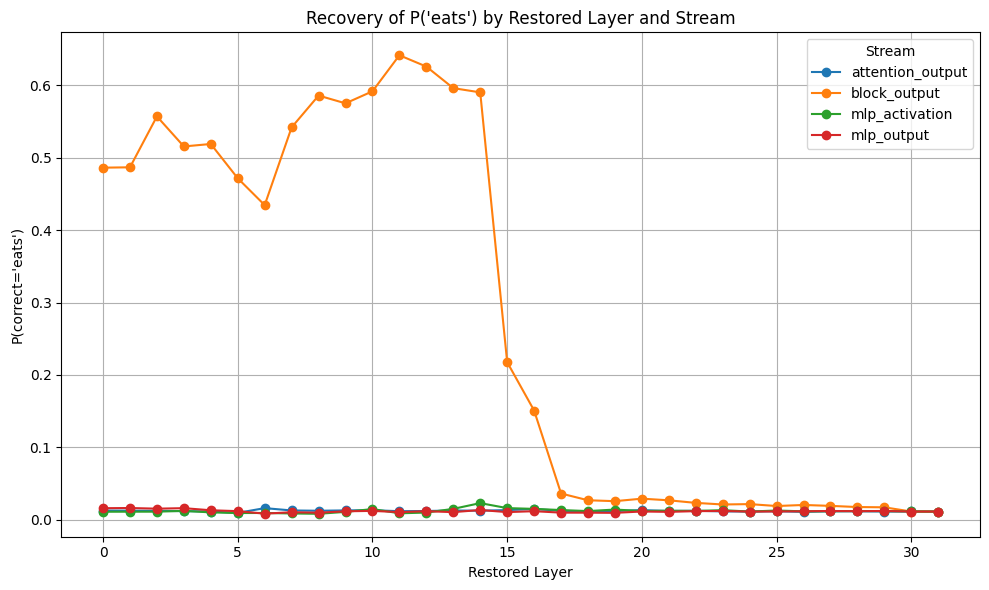

In [27]:
plt.figure(figsize=(10,6))
for stream, group in df_all.groupby("stream"):
    plt.plot(
        group["layer"],
        group["prob_correct"],
        marker="o",
        label=stream
    )

plt.title(f"Recovery of P('{gold}') by Restored Layer and Stream")
plt.xlabel("Restored Layer")
plt.ylabel(f"P(correct='{gold}')")
plt.legend(title="Stream")
plt.grid(True)
plt.tight_layout()
plt.show()

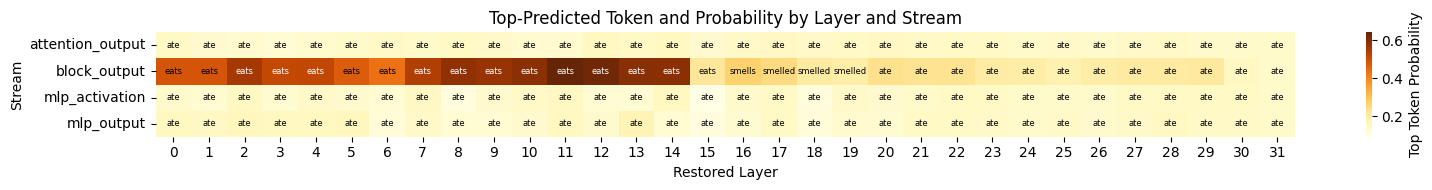

In [28]:
pivot_prob  = df_all.pivot(index="stream", columns="layer", values="top_prob")
pivot_token = df_all.pivot(index="stream", columns="layer", values="top_token")

# 2. Plot
plt.figure(figsize=(16, 2))
ax = sns.heatmap(
    pivot_prob, 
    annot=False, 
    fmt=".2f", 
    cmap="YlOrBr", 
    cbar_kws={"label": "Top Token Probability"}
)

# 3. Add top_token labels
for i, stream in enumerate(pivot_prob.index):
    for j, layer in enumerate(pivot_prob.columns):
        token = pivot_token.loc[stream, layer]
        prob  = pivot_prob.loc[stream, layer]
        if pd.notna(token):
            ax.text(
                j + 0.5, i + 0.5, token,
                ha="center", va="center",
                fontsize=6,
                color="black" if prob < 0.5 else "white"
            )

# 4. Aesthetics
ax.set_xlabel("Restored Layer")
ax.set_ylabel("Stream")
ax.set_title("Top-Predicted Token and Probability by Layer and Stream")
plt.tight_layout()
plt.show()